In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
!pip install xgboost
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [26]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']


In [42]:
#full_data = [train, test]
train.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age            0
Parch          0
Fare           0
Embarked       0
Name_length    0
Has_Cabin      0
FamilySize     0
IsAlone        0
Title          0
dtype: int64

In [37]:
test.isnull().sum()

Pclass         0
Sex            0
Age            0
Parch          0
Fare           0
Embarked       0
Name_length    0
Has_Cabin      0
FamilySize     0
IsAlone        0
Title          0
dtype: int64

In [27]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

#print(train['CategoricalFare'])

In [28]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    #stores number of nulls in each dataset that is train and test
    age_null_count = dataset['Age'].isnull().sum()
    #print(age_null_count)
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    #print(age_null_random_list)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
#print(train['CategoricalAge'])

In [29]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [30]:
#Cleaning Data
for dataset in full_data:
    #Mapping gender
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

In [31]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

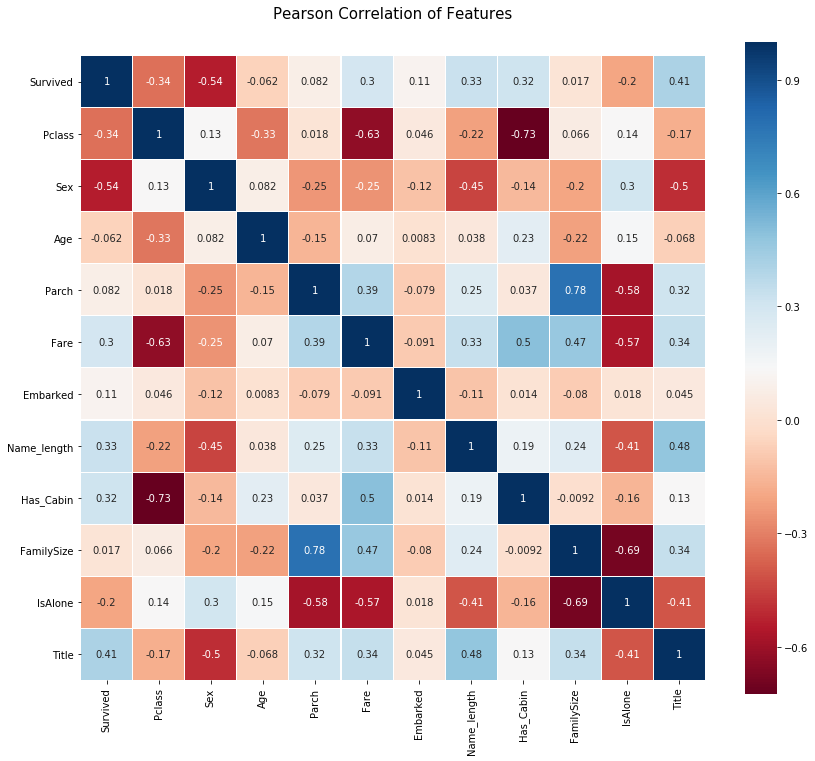

In [32]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [33]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [39]:
#Lets prepare data sets for training. 
#train,test=train_test_split(train,test_size=0.3,random_state=0,stratify=train['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
#test_Y=test[test.columns[:1]]
X=train[train.columns[1:]]
Y=train['Survived']
train_X.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1
1,1,0,2,0,3,1,51,1,2,0,3
2,3,0,1,0,1,0,22,0,1,1,2
3,1,0,2,0,3,0,44,1,2,0,3
4,3,1,2,0,1,0,24,0,1,1,1


In [40]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','Decision Tree','Naive Bayes','Random Forest']
models=[LogisticRegression(solver='liblinear'),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,train_X,train_Y, cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Logistic Regression,0.808065,0.026427
Decision Tree,0.795768,0.022568
Naive Bayes,0.782335,0.043132
Random Forest,0.808127,0.035376


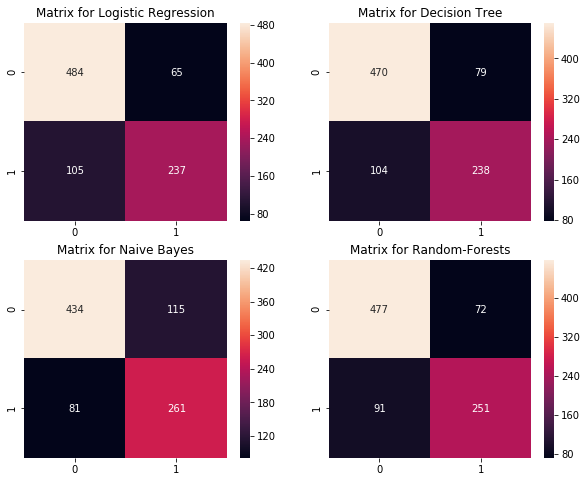

In [41]:
f,ax=plt.subplots(2,2,figsize=(10,8))
y_pred = cross_val_predict(LogisticRegression(C=0.05,solver='liblinear'),train_X,train_Y,cv=10)
sns.heatmap(confusion_matrix(train_Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),train_X,train_Y,cv=10)
sns.heatmap(confusion_matrix(train_Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),train_X,train_Y,cv=10)
sns.heatmap(confusion_matrix(train_Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Naive Bayes')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),train_X,train_Y,cv=10)
sns.heatmap(confusion_matrix(train_Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Random-Forests')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [44]:
#Ensembling
from sklearn.ensemble import VotingClassifier
estimators=[('RFor',RandomForestClassifier(n_estimators=100,random_state=0)),
            ('LR',LogisticRegression(C=0.05,solver='liblinear')),
            ('DT',DecisionTreeClassifier()),
            ('NB',GaussianNB())]
ensemble=VotingClassifier(estimators=estimators,voting='soft')
ensemble.fit(train_X,train_Y.values.ravel())
#print('The accuracy for ensembled model is:',ensemble.score(test_X))
cross=cross_val_score(ensemble,train_X,train_Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The cross validated score is 0.8350022698899103


In [45]:
Ensemble_Model_For_Prediction=VotingClassifier(estimators=[
                                       ('RFor',RandomForestClassifier(n_estimators=200,random_state=0)),
                                       ('LR',LogisticRegression(C=0.05,solver='liblinear')),
                                       ('DT',DecisionTreeClassifier(random_state=0)),
                                       ('NB',GaussianNB())
                                             ], 
                       voting='soft')
Ensemble_Model_For_Prediction.fit(train_X,train_Y)

VotingClassifier(estimators=[('RFor', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_...random_state=0,
            splitter='best')), ('NB', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [46]:
# Predict
test_Survived = pd.Series(ensemble.predict(test), name="Survived")
results = pd.concat([PassengerId,test_Survived],axis=1)
results.to_csv("predictions.csv",index=False)
